# Model ekonomiczny cen mieszkań w województwach Podkarpackim, Lubelskim, Świętokrzyskim i Małopolskin 

Celem naszego projektu było stworzenie jak najdokładniejszego modelu ekonomicznego prognozującego ceny mieszkań w oparciu o dane zebrane ze strony Gratka.pl. <br>


[Linkt do strony](https://gratka.pl/nieruchomosci?utm_source=google&utm_medium=cpc&utm_campaign=Brand&utm_adgroup=Brand&utm_term=gratka%20pl&utm_placement=&gad_source=1&gclid=Cj0KCQjwlN6wBhCcARIsAKZvD5hMwd1STwd6Zf7mhIqdZIls0aFhRaw0uuD_s-9zMJz4tYSvBLDXT6AaAuD1EALw_wcB)

<br> 
Z racji na tworzenie modelu w oparciu o drzewa decyzyjne wykorzystaliśmy dużą ilość parametrów do wykonywania prognoz, używając tak naprawdę praktycznie każdej zebranej kolumny w której występowała jakakolwiek zmienność


### Wizualizacja, w celu przestawienia obszaru, na którym są mieszkania uwzględnione w naszym modelu

NameError: name 'X_latlon' is not defined

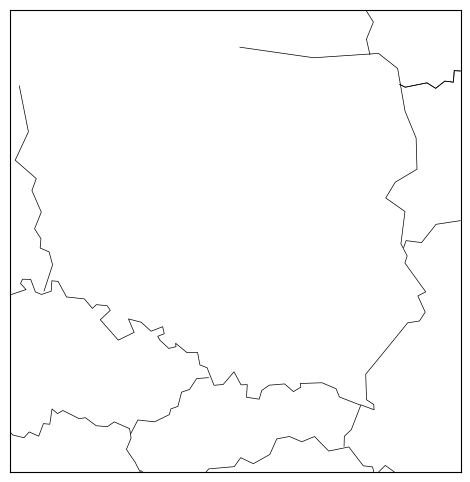

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Tworzenie wykresu
plt.figure(figsize=(10, 6))

# Inicjalizacja mapy Polski
map = Basemap(projection='merc', resolution='l', llcrnrlon=14, llcrnrlat=48, urcrnrlon=25, urcrnrlat=55)

# Rysowanie granic Polski
map.drawcountries()

# Rysowanie wybranych punktów
for cluster_label in np.unique(X_latlon["Cluster"]):
    cluster_data = X_latlon[X_latlon["Cluster"] == cluster_label]
    x, y = map(cluster_data["longitude"].values, cluster_data["latitude"].values)
    map.scatter(x, y, alpha=0.5)

# Wyświetlenie wykresu
plt.show()

### Wczywanie naszych danych 

Import biblioteki pandas służącej do wykonywania operacji na ramkach danych

In [78]:
import pandas as pd

Wczytanie zebranych danych dotyczących mieszkań 

In [79]:
df = pd.read_csv('dane.csv')

C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\1245168186.py:1: DtypeWarning: Columns (63,64,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dane.csv')


In [80]:
df = df.rename(columns={'Miasto':'region'})

In [81]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

# Inicjalizuj geocoder
geolocator = Nominatim(user_agent="my_geocoder")

# Iteruj przez unikalne miasta
for city in df['region'].unique():
    try:
        # Pobierz współrzędne geograficzne dla danego miasta
        location = geolocator.geocode(city)
        if location:
            latitude = location.latitude
            longitude = location.longitude

            # Skopiuj współrzędne do wszystkich wystąpień tego miasta
            df.loc[df['region'] == city, 'latitude'] = latitude
            df.loc[df['region'] == city, 'longitude'] = longitude
            
        else:
            print(f"Nie udało się znaleźć współrzędnych dla miasta: {city}")
    except GeocoderTimedOut as e:
        print(f"Błąd podczas pobierania współrzędnych dla miasta {city}: {str(e)}")

# Zapisz zmienioną ramkę danych
df.to_csv('zmodyfikowany_plik.csv', index=False)  # Zastąp 'zmodyfikowany_plik.csv' odpowiednią nazwą pliku wyjściowego

In [203]:
df = pd.read_csv('zmodyfikowany_plik.csv')

C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\1321659063.py:1: DtypeWarning: Columns (63,64,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('zmodyfikowany_plik.csv')


## Wyciągniecie z kolumn najistotniejszych informacji

Czyszczenie ze zbędnych zanków zmiennych które będą wykorzystywane do tworzenia modelu

In [204]:
df['region'] = df['region'].str.replace(',', '')
df['total_price'] = df['total_price'].str.replace(r'\s+|\\n', '', regex=True)
df['total_price'] = df['total_price'].str.replace('zł', '')
df['additional_price_per_m2'] = df['additional_price_per_m2'].str.replace('zł/m2', '')
df['additional_price_per_m2'] = df['additional_price_per_m2'].str.replace(',', '.')
df['Powierzchnia w m2'] = df['Powierzchnia w m2'].str.replace(',', '.')
df['Powierzchnia w m2'] = df['Powierzchnia w m2'].str.replace(' m2', '')
df['region'] = df['region'].str.replace(',', '')

Zamiana typów danych z tekstowych na liczbowe oraz usunięcie braków danych

In [205]:
df['Liczba pokoi'] = pd.to_numeric(df['Liczba pokoi'], errors='coerce')
df.dropna(subset=['Liczba pokoi'], inplace=True)

df['Piętro'] = pd.to_numeric(df['Piętro'], errors='coerce')
df.dropna(subset=['Piętro'], inplace=True)

df['Liczba pięter w budynku'] = pd.to_numeric(df['Liczba pięter w budynku'], errors='coerce')
df.dropna(subset=['Liczba pięter w budynku'], inplace=True)

df['total_price'] = pd.to_numeric(df['total_price'], errors='coerce')
df.dropna(subset=['total_price'], inplace=True)

df['Powierzchnia w m2'] = pd.to_numeric(df['Powierzchnia w m2'], errors='coerce')
df.dropna(subset=['Powierzchnia w m2'], inplace=True)

Podgląd ramki danych po wyczyszczeniu kolumn ze zmiennymi <br>

In [206]:
df.head()

,Unnamed: 0.1,Unnamed: 0,region,title,total_price,additional_price_per_m2,opis,Lokalizacja,Powierzchnia w m2,Liczba pokoi,...,Powiat,Powierzchnia [ha] (01.01.2021),Liczba ludności (01.01.2021),Gęstość zaludnienia [osoby/km²] (01.01.2021),wynagrodzenie_brutto,śr_wydatki_gosp_dom,aktywność_zawodowa_pro,wsp_dzietności,latitude,longitude
1,1,33,Terespol,Mieszkanie Terespol,299000.0,6 346.85,Oferujemy na sprzedaż mieszkanie usytuowane n...,"Terespol, ...",47.11,2.0,...,bialski,1011,5457,540,"5069,14","1399,56","80,2","1,229",52.075617,23.613364
4,4,36,Lublin,Przestronne w bloku z cegły. Duży parking do d...,454998.0,9 891.26,Mieszkanie w trakcie generalnego remontu.Zakre...,"Lublin, ...",46.00,3.0,...,Lublin[a],14747,338586,2296,"5069,14","1399,56","80,2","1,229",51.218195,22.554678
5,5,37,Lublin,"Rudnik/Dożynkowa, Wykończone do wejścia od zaraz.",579998.0,12 946.38,Mieszkanie dostępne do wejścia.Nowy blok przy ...,"Lublin, ...",44.80,2.0,...,Lublin[a],14747,338586,2296,"5069,14","1399,56","80,2","1,229",51.218195,22.554678
7,7,39,Chełm,"Atrakcyjny apartament, 3 pokoje, centrum Chełma!",315000.0,7 954.55,Kupujący zwolniony z podatku PCC!Do mieszkania...,"Chełm, ...",39.60,3.0,...,Chełm[a],3528,61135,1733,"5069,14","1399,56","80,2","1,229",51.133922,23.471155
19,19,51,Lublin,"Mieszkanie Lublin Śródmieście, ul. Legionowa",395000.0,10 675.68,"DWA ODDZIELNE POKOJE! ODDZIELNA, WIDNA KUCHNIA...","Lublin, ...",37.00,2.0,...,Lublin[a],14747,338586,2296,"5069,14","1399,56","80,2","1,229",51.218195,22.554678


# Tworzenie modelu
* #### wybór parametrów na podstawie, których będziemy przewidywać
* #### wybór co będziemy przewidywać

## Czynniki wpływające na cenę mieszkań, które bierzemy pod uwagę oraz powody naszego wyboru

* **Lokalizacj**
  * najistotniejszy warunek w wyborze mieszkania 
  * mieszkania w dużych miastach są droższe 
  * usytuowanie mieszkania w danym mieście też jest ważne


* **Liczba pokoi**: z ilu pokoi składa się mieszkanie
  *  Większe mieszkania mogą przyciągać inne rodzaje najemców, takie jak grupy współlokatorów, co może zwiększyć potencjalne dochody z najmu. 
  * Wzrastają koszty remontu każdy pokój trzeba wyposażyć w oświetlenie drzwi, potrzeba dużo więcej mebli 

* **Piętro**: na którym pietrze znajduje się mieszkanie 
  * zwykle nikt nie chce kupować mieszkan na **pierwszym piętrze: przechodnie widzą bardzo dobrze co robisz** w mieszkaniu oraz **ostatnim: lęk przed problemami z przeciekającym dachem** oraz wszelkimi problemami z nim związanymi
  * chodzenie po schodach może być uciążliwe

* **Powierzchnia w m²**
  * zwykle większe mieszkania są tańsze jeśli chodzi o cenę za metr 
  * różny typ klientów 

* **Rok budowy**
 * w zależności od roku budowy próbujemy określić stan budynku
 * to jak długo wytrzyma konstrukcja 
 * techniki stosowane w budownictwie 
 * to czy budynek jest zabytkiem i konserwator zabytków wyda zgodę na remont budynku

* **Typ zabudowy**
  * użyte materiały 
  * stylistyka budynku
  * trwałość budynku
  * użyte materiały i techniki
  * to czy na przykład sufit i ściany będą pękać na całej długości (zabudowa z wielkiej płyty)

* **Forma kuchni**
  * design mieszkania 
  * preferencje klientów 

* **Materiał budynku**
  * trwałość
  * izolację termiczną i akustyczną
  * wygląd zewnętrzny

* **Stan instalacji**
  * wymiana instalacji powoduje duże koszty 
  * potrzeba zatrudnienia elektryka oraz fachowców do przygotowania ścian 

* **Stan łazienki**
  * remont jest bardzo kosztowny 
  * prace są długie
  * mieszkanie jest praktycznie wyłączone z użytku podczas remontu

* **Okna**
  * wpływ na izolacje termiczną oraz akustykę

* **Forma własności**
  * problemy z mieszkaniami po postępowaniach sądowych w których mieszkają poprzedni lokatorzy, których nie mozna się pozbyc
  * zadłużenie mieszkania do spłacenia
  * hipoteka
  * mieszkanie z dużą liczbą współwłaścieli 

* **Głośność**
  * większość ludzi nie chce słyszeć co dzieje się w mieszkaniu obok lub odgłosów z ulicy

* **Usytuowanie względem stron świata**
  * to czy do mieszkania wpada dużo światła może zmniejszyć rachunki za prąd
  * niektórzy zwracają uwagę w jakich porach w jakich pomieszczeniach przebywają i czy będą mieli wtedy w nich światło słoneczne


* **Miejsce parkingowe**
  * istotny atut mieszkania nawt dla osoby bez auta, która może podnajmować miejsce parkinowe innym

* **Stan**
  * ogólny stan mieszkania 
  * czy nadaje się do zamieszkania w stopniu zadowalającym


### Uważamy, że **lokalizacja jest najważniejszym czynnikiem** wpływającym na cenę mieszkania:
  * Dostępność do usług i udogodnień
  * Komunikacja
  * Bezpieczeństwo
  * Jakość życia
  * Potencjał wzrostu zawodowego
  * Możliwości




### Przypisanie zmiennych do tabeli X oraz tabeli y.
<br>
X to ramka zawierająca informacje dotyczące specyfikacji mieszkania oraz aspektów dotyczacych kwestii technicznych.
Y to ifnormacje dotyczące ceny mieszkania oraz roboczo usuwane później informacje dotyczące ceny za m<sup>2</sup>

In [207]:
df['wynagrodzenie_brutto'] = df['wynagrodzenie_brutto'].str.replace(',', '.')
df['śr_wydatki_gosp_dom'] = df['śr_wydatki_gosp_dom'].str.replace(',', '.')
df['aktywność_zawodowa_pro'] = df['aktywność_zawodowa_pro'].str.replace(',', '.')
df['wsp_dzietności'] = df['wsp_dzietności'].str.replace(',', '.')

df['wynagrodzenie_brutto'] = pd.to_numeric(df['wynagrodzenie_brutto'], errors='coerce')
df['śr_wydatki_gosp_dom'] = pd.to_numeric(df['śr_wydatki_gosp_dom'], errors='coerce')
df['aktywność_zawodowa_pro'] = pd.to_numeric(df['aktywność_zawodowa_pro'], errors='coerce')
df['wsp_dzietności'] = pd.to_numeric(df['wsp_dzietności'], errors='coerce')

In [208]:
df

,Unnamed: 0.1,Unnamed: 0,region,title,total_price,additional_price_per_m2,opis,Lokalizacja,Powierzchnia w m2,Liczba pokoi,...,Powiat,Powierzchnia [ha] (01.01.2021),Liczba ludności (01.01.2021),Gęstość zaludnienia [osoby/km²] (01.01.2021),wynagrodzenie_brutto,śr_wydatki_gosp_dom,aktywność_zawodowa_pro,wsp_dzietności,latitude,longitude
1,1,33,Terespol,Mieszkanie Terespol,299000.0,6 346.85,Oferujemy na sprzedaż mieszkanie usytuowane n...,"Terespol, ...",47.11,2.0,...,bialski,1011,5457,540,5069.14,1399.56,80.2,1.229,52.075617,23.613364
4,4,36,Lublin,Przestronne w bloku z cegły. Duży parking do d...,454998.0,9 891.26,Mieszkanie w trakcie generalnego remontu.Zakre...,"Lublin, ...",46.00,3.0,...,Lublin[a],14747,338586,2296,5069.14,1399.56,80.2,1.229,51.218195,22.554678
5,5,37,Lublin,"Rudnik/Dożynkowa, Wykończone do wejścia od zaraz.",579998.0,12 946.38,Mieszkanie dostępne do wejścia.Nowy blok przy ...,"Lublin, ...",44.80,2.0,...,Lublin[a],14747,338586,2296,5069.14,1399.56,80.2,1.229,51.218195,22.554678
7,7,39,Chełm,"Atrakcyjny apartament, 3 pokoje, centrum Chełma!",315000.0,7 954.55,Kupujący zwolniony z podatku PCC!Do mieszkania...,"Chełm, ...",39.60,3.0,...,Chełm[a],3528,61135,1733,5069.14,1399.56,80.2,1.229,51.133922,23.471155
19,19,51,Lublin,"Mieszkanie Lublin Śródmieście, ul. Legionowa",395000.0,10 675.68,"DWA ODDZIELNE POKOJE! ODDZIELNA, WIDNA KUCHNIA...","Lublin, ...",37.00,2.0,...,Lublin[a],14747,338586,2296,5069.14,1399.56,80.2,1.229,51.218195,22.554678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527,13527,9098,Tarnów,"Mieszkanie Tarnów Strusina, ul. Szujskiego",299000.0,6 644.44,2 - pokojowe MIESZKANIE w DOSKONAŁEJ LOKALIZAC...,"Tarnów, ...",45.00,2.0,...,Tarnów[a],7238,107498,1485,5672.84,1263.21,76.8,1.286,50.025988,20.964058
13528,13528,9099,Tarnów,"Nowe mieszkanie Tarnów, ul. Żeromskiego",475000.0,9 481.04,Luksusowy kameralny apartamentowiec przy ul. Ż...,"Tarnów, ...",50.10,3.0,...,Tarnów[a],7238,107498,1485,5672.84,1263.21,76.8,1.286,50.025988,20.964058
13529,13529,9100,Tarnów,"Nowe mieszkanie Tarnów, ul. Żeromskiego",478500.0,9 495.93,Luksusowy kameralny apartamentowiec przy ul. Ż...,"Tarnów, ...",50.39,3.0,...,Tarnów[a],7238,107498,1485,5672.84,1263.21,76.8,1.286,50.025988,20.964058
13530,13530,9101,Tarnów,"Nowe mieszkanie Tarnów, ul. Żeromskiego",515000.0,9 792.74,Luksusowy kameralny apartamentowiec przy ul. Ż...,"Tarnów, ...",52.59,3.0,...,Tarnów[a],7238,107498,1485,5672.84,1263.21,76.8,1.286,50.025988,20.964058


In [209]:
X = df[['region', 'Liczba pokoi','Piętro','Powierzchnia w m2','Rok budowy',
       'Typ zabudowy', 'Liczba pięter w budynku','Forma kuchni', 'Materiał budynku', 'Stan instalacji','Stan łazienki','Okna','Forma własności','Głośność',
'Usytuowanie względem stron świata','Miejsce parkingowe','Stan','Liczba miejsc parkingowych',
       'latitude', 'longitude', 'Powierzchnia [ha] (01.01.2021)',
       'Liczba ludności (01.01.2021)',
       'Gęstość zaludnienia [osoby/km²] (01.01.2021)','wynagrodzenie_brutto', 'śr_wydatki_gosp_dom',
       'aktywność_zawodowa_pro', 'wsp_dzietności']]

y = df[['total_price', 'additional_price_per_m2']]

In [210]:
df[['Powierzchnia [ha] (01.01.2021)',
    'Liczba ludności (01.01.2021)',
    'Gęstość zaludnienia [osoby/km²] (01.01.2021)',
    'wynagrodzenie_brutto',
    'śr_wydatki_gosp_dom',
    'aktywność_zawodowa_pro',
    'wsp_dzietności']]


,Powierzchnia [ha] (01.01.2021),Liczba ludności (01.01.2021),Gęstość zaludnienia [osoby/km²] (01.01.2021),wynagrodzenie_brutto,śr_wydatki_gosp_dom,aktywność_zawodowa_pro,wsp_dzietności
1,1011,5457,540,5069.14,1399.56,80.2,1.229
4,14747,338586,2296,5069.14,1399.56,80.2,1.229
5,14747,338586,2296,5069.14,1399.56,80.2,1.229
7,3528,61135,1733,5069.14,1399.56,80.2,1.229
19,14747,338586,2296,5069.14,1399.56,80.2,1.229
...,...,...,...,...,...,...,...
13527,7238,107498,1485,5672.84,1263.21,76.8,1.286
13528,7238,107498,1485,5672.84,1263.21,76.8,1.286
13529,7238,107498,1485,5672.84,1263.21,76.8,1.286
13530,7238,107498,1485,5672.84,1263.21,76.8,1.286


In [211]:
X.dtypes

region                                           object
Liczba pokoi                                    float64
Piętro                                          float64
Powierzchnia w m2                               float64
Rok budowy                                      float64
Typ zabudowy                                     object
Liczba pięter w budynku                         float64
Forma kuchni                                     object
Materiał budynku                                 object
Stan instalacji                                  object
Stan łazienki                                    object
Okna                                             object
Forma własności                                  object
Głośność                                         object
Usytuowanie względem stron świata                object
Miejsce parkingowe                               object
Stan                                             object
Liczba miejsc parkingowych                      

In [212]:
X_region = X[['region','Powierzchnia [ha] (01.01.2021)','Liczba ludności (01.01.2021)',
       'Gęstość zaludnienia [osoby/km²] (01.01.2021)', 'wynagrodzenie_brutto']]

**Wykorzystanie metody _OrdilaEncoding_** w celu szybkiego przekształcenie danych o wartościach tekstowych takich jak np materiał z którego zbudowany jest blok, na wartości liczbowe. <br>
Tym sposobem **uzyskujemy zmiennych kategorycznych z liczb**, które określają różne aspekty mieszkania oraz budynku, w którym znajduje się mieszkanie.

In [213]:
from sklearn.preprocessing import OrdinalEncoder

# Inicjalizacja kodera
enc = OrdinalEncoder()

# Przekształcenie i zastąpienie wartości dla kolejnych zmiennych
encoded_values1 = enc.fit_transform(X[['Typ zabudowy']])
encoded_values2 = enc.fit_transform(X[['Forma kuchni']])
encoded_values3 = enc.fit_transform(X[['Materiał budynku']])
encoded_values4 = enc.fit_transform(X[['Stan instalacji']])
encoded_values5 = enc.fit_transform(X[['Stan łazienki']])
encoded_values6 = enc.fit_transform(X[['Okna']])
encoded_values7 = enc.fit_transform(X[['Forma własności']])
encoded_values8 = enc.fit_transform(X[['Głośność']])
encoded_values9 = enc.fit_transform(X[['Miejsce parkingowe']])
encoded_values10 = enc.fit_transform(X[['Stan']])
encoded_values11 = enc.fit_transform(X[['Liczba miejsc parkingowych']])
encoded_values12 = enc.fit_transform(X[['Usytuowanie względem stron świata']])
encoded_values13 = enc.fit_transform(X[['region']])

# Zastąpienie kolumn oryginalnych zmiennych przekształconymi wartościami
X['Typ zabudowy'] = encoded_values1
X['Forma kuchni'] = encoded_values2
X['Materiał budynku'] = encoded_values3
X['Stan instalacji'] = encoded_values4
X['Stan łazienki'] = encoded_values5
X['Okna'] = encoded_values6
X['Forma własności'] = encoded_values7
X['Głośność'] = encoded_values8
X['Miejsce parkingowe'] = encoded_values9
X['Stan'] = encoded_values10
X['Liczba miejsc parkingowych'] = encoded_values11
X['Usytuowanie względem stron świata'] = encoded_values12
X['region'] = encoded_values13

C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\2815592270.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Typ zabudowy'] = encoded_values1
C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\2815592270.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Forma kuchni'] = encoded_values2
C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\2815592270.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

### Czynności sprawdzające nasze dane

Usunięcie zmiennej określającej cenę za metr <sup>2<sup>

In [214]:
y = y.drop('additional_price_per_m2', axis=1)

Sprawdzenie czy wszystkie zmienne zawierają tylko wartości liczbowe

In [215]:
X.dtypes

region                                          float64
Liczba pokoi                                    float64
Piętro                                          float64
Powierzchnia w m2                               float64
Rok budowy                                      float64
Typ zabudowy                                    float64
Liczba pięter w budynku                         float64
Forma kuchni                                    float64
Materiał budynku                                float64
Stan instalacji                                 float64
Stan łazienki                                   float64
Okna                                            float64
Forma własności                                 float64
Głośność                                        float64
Usytuowanie względem stron świata               float64
Miejsce parkingowe                              float64
Stan                                            float64
Liczba miejsc parkingowych                      

In [216]:
X

,region,Liczba pokoi,Piętro,Powierzchnia w m2,Rok budowy,Typ zabudowy,Liczba pięter w budynku,Forma kuchni,Materiał budynku,Stan instalacji,...,Liczba miejsc parkingowych,latitude,longitude,Powierzchnia [ha] (01.01.2021),Liczba ludności (01.01.2021),Gęstość zaludnienia [osoby/km²] (01.01.2021),wynagrodzenie_brutto,śr_wydatki_gosp_dom,aktywność_zawodowa_pro,wsp_dzietności
1,91.0,2.0,2.0,47.11,2015.0,1.0,3.0,0.0,5.0,NaN,...,NaN,52.075617,23.613364,1011,5457,540,5069.14,1399.56,80.2,1.229
4,44.0,3.0,1.0,46.00,1960.0,1.0,3.0,2.0,1.0,2.0,...,NaN,51.218195,22.554678,14747,338586,2296,5069.14,1399.56,80.2,1.229
5,44.0,2.0,1.0,44.80,2023.0,1.0,3.0,2.0,8.0,1.0,...,0.0,51.218195,22.554678,14747,338586,2296,5069.14,1399.56,80.2,1.229
7,13.0,3.0,2.0,39.60,NaN,3.0,3.0,NaN,NaN,NaN,...,NaN,51.133922,23.471155,3528,61135,1733,5069.14,1399.56,80.2,1.229
19,44.0,2.0,2.0,37.00,1955.0,3.0,3.0,NaN,1.0,NaN,...,NaN,51.218195,22.554678,14747,338586,2296,5069.14,1399.56,80.2,1.229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13527,90.0,2.0,3.0,45.00,NaN,NaN,4.0,0.0,NaN,NaN,...,NaN,50.025988,20.964058,7238,107498,1485,5672.84,1263.21,76.8,1.286
13528,90.0,3.0,1.0,50.10,NaN,0.0,2.0,2.0,NaN,NaN,...,0.0,50.025988,20.964058,7238,107498,1485,5672.84,1263.21,76.8,1.286
13529,90.0,3.0,2.0,50.39,NaN,NaN,2.0,2.0,NaN,NaN,...,0.0,50.025988,20.964058,7238,107498,1485,5672.84,1263.21,76.8,1.286
13530,90.0,3.0,2.0,52.59,NaN,NaN,2.0,2.0,NaN,NaN,...,0.0,50.025988,20.964058,7238,107498,1485,5672.84,1263.21,76.8,1.286


In [217]:
# Obliczenie macierzy korelacji
correlation_matrix = X.corr()

# Obliczenie macierzy odwrotnej
inverse_correlation_matrix = np.linalg.inv(correlation_matrix)

# Usuwanie zmiennych 
threshold = 10
variables_to_remove = []

for i in range(len(inverse_correlation_matrix)):
    if inverse_correlation_matrix[i, i] > threshold:
        variables_to_remove.append(X.columns[i])

# Usunięcie zmiennych i przypisane nowej ramki danych do ramki danych
X_filtered = X.drop(variables_to_remove, axis=1)

print("Zmienne do usunięcia:", variables_to_remove)
print("Dane po usunięciu zmiennych:")
print(X_filtered)

# Ponowne przypisane do tabeli X kolumn ze mnienne X_filtered
X = X_filtered

Zmienne do usunięcia: ['latitude', 'longitude']
Dane po usunięciu zmiennych:
       region  Liczba pokoi  Piętro  Powierzchnia w m2  Rok budowy  \
1        91.0           2.0     2.0              47.11      2015.0   
4        44.0           3.0     1.0              46.00      1960.0   
5        44.0           2.0     1.0              44.80      2023.0   
7        13.0           3.0     2.0              39.60         NaN   
19       44.0           2.0     2.0              37.00      1955.0   
...       ...           ...     ...                ...         ...   
13527    90.0           2.0     3.0              45.00         NaN   
13528    90.0           3.0     1.0              50.10         NaN   
13529    90.0           3.0     2.0              50.39         NaN   
13530    90.0           3.0     2.0              52.59         NaN   
13531    90.0           2.0     2.0              52.70         NaN   

       Typ zabudowy  Liczba pięter w budynku  Forma kuchni  Materiał budynku  \
1 

In [218]:
# Obliczenie współczynnika zmienności 
cv = X.std() / X.mean()

# Ustawienie progu poniżej którego uznajemy zmienne za zmienne quasi-stałe
cv_threshold = 0.05 

# Znalezienie kolumn posiadających bardzo niski współczynnik zmienności
low_cv = X.columns[cv < cv_threshold]

# Usunięcie zmiennych quasi stałych
X_filtered = X.drop(low_cv, axis=1)

print("Zmienne quasi-stałe usunięte na podstawie współczynnika zmienności:", low_cv)

# Ponowne przypisane do tabeli X kolumn ze mnienne X_filtered
X = X_filtered

Zmienne quasi-stałe usunięte na podstawie współczynnika zmienności: Index(['Rok budowy', 'śr_wydatki_gosp_dom', 'aktywność_zawodowa_pro',
       'wsp_dzietności'],
      dtype='object')


### Kod dzielący na dane testowe i terningowe oraz model

Podział zbioru z danymi na dane testowe oraz treningowe. Treningowe użytych do stworzenia modelu odpowiedzialnego z późniejsze tworzenie prognoz dotyczaccyh cen mieszkań oraz testowe, na których następnie sprawdzamy jak dokładne są prognozy przygotowane przez model <br>
Następnie występuje import algorytmu uczenia maszynowego _RandomForrest_ wykorzystywanym przez nas następnie do obliczenia zalezności między ceną ze zmienney *y* oraz informacjami z tabeli *df*

In [219]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42, n_estimators=200, bootstrap=True)
model.fit(X_train,y_train)

predictions = model.predict(X_test)

c:\Projekty\Podstawy_ekonometrii\apartment_price_prediction\venv\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Miara dokładności naszego modelu

Obliczenie przy pomocy zmiennej mean_absolute_error dokładności modelu wyliczając jak dokładne są jego przewidywania w oparciu o porównywanie przeprowadzanych obliczeń z danymi testowymi <br>
Na testowych danych z tabeli _X_ przeprowadzamy obliczenia i porównujemy je z wynikami z testowych danych _y_ <br>
Otrzymany przez nas wynik to **87** procent

In [220]:
from sklearn.metrics import mean_absolute_error
import statistics
mae = mean_absolute_error(predictions,y_test)
mean_total_price = statistics.mean(y['total_price'])
accuracy = 1 - mae/mean_total_price
print(accuracy)

0.8744954149624803


In [221]:
df = pd.read_csv('zmodyfikowany_plik.csv')

C:\Users\Szymon\AppData\Local\Temp\ipykernel_20764\1321659063.py:1: DtypeWarning: Columns (63,64,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('zmodyfikowany_plik.csv')


Przypisanie miastom ich nowych wygenerowanych id

In [222]:
cities = pd.DataFrame()
cities[['miasto', 'Powierzchnia [ha] (01.01.2021)', 'Liczba ludności (01.01.2021)',
       'Gęstość zaludnienia [osoby/km²] (01.01.2021)', 'wynagrodzenie_brutto']] = X_region
cities['id_miasta'] = X['region']
cities = cities.drop_duplicates()
cities

,miasto,Powierzchnia [ha] (01.01.2021),Liczba ludności (01.01.2021),Gęstość zaludnienia [osoby/km²] (01.01.2021),wynagrodzenie_brutto,id_miasta
1,Terespol,1011,5457,540,5069.14,91.0
4,Lublin,14747,338586,2296,5069.14,44.0
7,Chełm,3528,61135,1733,5069.14,13.0
70,Józefów,500,2473,495,5069.14,24.0
109,Rejowiec,650,2026,312,5069.14,71.0
...,...,...,...,...,...,...
5713,Niepołomice,2740,14022,512,5672.84,50.0
5839,Wieliczka,1341,24215,1806,5672.84,97.0
6159,Kraków,32685,779966,2386,5672.84,31.0
13276,Nowy Sącz,5758,83558,1451,5672.84,54.0


In [223]:
def id_city(city_name, df=cities):
    filtered_df = df[df['miasto'] == city_name]
    if not filtered_df.empty:
        return filtered_df[['id_miasta', 'Powierzchnia [ha] (01.01.2021)','Liczba ludności (01.01.2021)',
       'Gęstość zaludnienia [osoby/km²] (01.01.2021)', 'wynagrodzenie_brutto']].iloc[0]
    else:
        return None

In [224]:
X.columns

Index(['region', 'Liczba pokoi', 'Piętro', 'Powierzchnia w m2', 'Typ zabudowy',
       'Liczba pięter w budynku', 'Forma kuchni', 'Materiał budynku',
       'Stan instalacji', 'Stan łazienki', 'Okna', 'Forma własności',
       'Głośność', 'Usytuowanie względem stron świata', 'Miejsce parkingowe',
       'Stan', 'Liczba miejsc parkingowych', 'Powierzchnia [ha] (01.01.2021)',
       'Liczba ludności (01.01.2021)',
       'Gęstość zaludnienia [osoby/km²] (01.01.2021)', 'wynagrodzenie_brutto'],
      dtype='object')

### Prezentacja działania modelu

Wprowadzanie do modelu własnych hipotetycznych danych. <br>
Wprowadzenie polega na podaniu 20 zmiennych, na podstawie których następnie model wykonuje wyliczenie estymowwanej ceny mieszkania

In [234]:
id_miasta, powierzchnia_wojewodztwa, ludnośc_miasta, Gestosc_zaludnienia, wynagrodzenie_wojewodztwo  = id_city('Kraków')

liczba_pokoi = 4.0

pietro = 2.0

metry_2 = 25.26

# Typ zabudowy = [0:'blok' 1:'apartamentowiec' 2:nan 3:'kamienica' 4:'dom wielorodzinny/szeregowiec']
typ_zabudowy = 1.0

liczba_pieter_w_budynku = 7.0

# Forma kuchni: [0:'oddzielna' 1:'w aneksie' 2:nan 3:'prześwit']
forma_kuchni = 0

# Materiał budynku: [0:'płyta' 1:'cegła' 2:nan 3:'beton' 4:'pustak' 5:'drewno' 6:'rama H' 7:'kamień' 8:'inne' 9:'silikat']
materiał_budynku = 1

# Stan instalacji: [0:nan 1:'nowa' 2:'częściowo wymieniona' 3:'po wymianie' 4:'do wymiany']
stan_instalacji = 1

# Stan łazienki: [0:nan 1:'bardzo dobry' 2:'do remontu' 3:'do odnowienia' 4:'dobry']
stan_łazienki = 1

# Okna: [0:nan 1:'plastikowe/PCV' 2:'drewniane' 3:'aluminiowe']
okna = 2

# Forma własności: [0:'własność' 1:nan 2:'spółdzielcze własnościowe' 3:'spółdzielcze własnościowe z KW' 4:'udział']
forma_wlasnosci = 0

# Głośność: [0:nan 1:'ciche' 2:'umiarkowanie ciche' 3:'umiarkowanie głośne']
głośność = 0

# Usytuowanie względem stron świata: [0:nan 1:'północne, południowe' 2:'południowe, północne, wschodnie, zachodnie' 3:'południowe, zachodnie' 4:'zachodnie' 5:'południowe, wschodnie' 6:'południowe' 7:'wschodnie, zachodnie' 8:'południowe, północne' 9:'południowe, zachodnie, wschodnie, północne' 10:'północne, południowe, wschodnie, zachodnie' 11:'północne, wschodnie' 12:'wschodnie' 13:'wschodnie, południowe' 14:'zachodnie, południowe' 15:'południowe, wschodnie, północne, zachodnie' 16:'północne' 17:'zachodnie, wschodnie' 18:'zachodnie, północne' 19:'wschodnie, zachodnie, północne']
usytuowanie_względem_stron_świata = 10

# Miejsce parkingowe: [0:'w garażu' 1:nan 2:'przynależne na ulicy' 3:'brak miejsca parkingowego' 4:'parking strzeżony']
miejsce_parkingowe = 2

# Stan: [0:'wysoki standard' 1:'do odświeżenia' 2:nan 3:'dobry' 4:'do remontu' 5:'stan deweloperski' 6:'świeżo po remoncie']
stan = 1

liczba_miejsc_parkingowych = 2

# Zdefiniujmy dane wejściowe
input_data2 = [
    id_miasta, liczba_pokoi, pietro, metry_2,  typ_zabudowy, liczba_pieter_w_budynku,
    forma_kuchni, materiał_budynku, stan_instalacji, stan_łazienki, okna, forma_wlasnosci, głośność,
    usytuowanie_względem_stron_świata, miejsce_parkingowe, stan, liczba_miejsc_parkingowych,
    powierzchnia_wojewodztwa, ludnośc_miasta, Gestosc_zaludnienia, wynagrodzenie_wojewodztwo
]

# Przewidywanie
prediction = model.predict([input_data2])
rounded_prediction = round(prediction[0], 2)
print("Przewidywana cena:", rounded_prediction)


Przewidywana cena: 420545.36


c:\Projekty\Podstawy_ekonometrii\apartment_price_prediction\venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
